### Draw T-SNE plot for the unconditional diffusion model on Cifar10 

model load weight done.


  4%|▍         | 100/2500 [00:01<00:39, 60.08it/s]
/afs/crc.nd.edu/user/d/dzeng2/.conda/envs/py3.9/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


<Figure size 600x600 with 0 Axes>

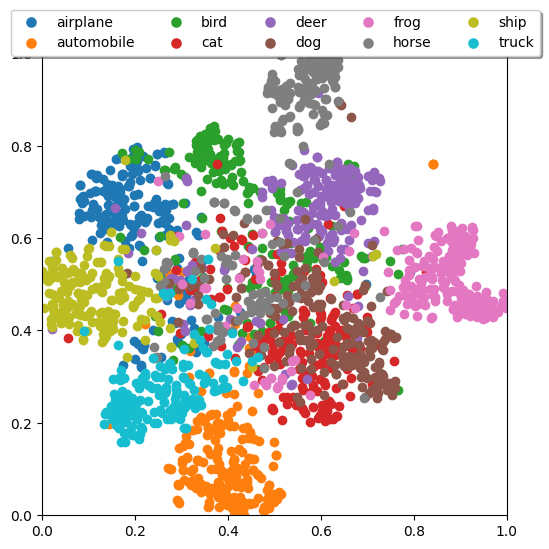

In [44]:
import os
import torch
import yaml
import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from ddpm import GaussianDiffusionSampler
from models.unet import UNet
from torchvision.utils import make_grid
from tqdm import tqdm
from sklearn import manifold
import matplotlib
import matplotlib.pyplot as plt


config_file = "configs/diffusion_cifar10.yaml"
ckpt_path = "./pretrained_ckpts/uncondition_diffusion_cifar10.pt"

with open(config_file) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

dataset = datasets.CIFAR10(
    root=config["data_path"], 
    train=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    download=False,
)

dataloader = DataLoader(dataset, batch_size=20, shuffle=True, num_workers=0, drop_last=False, pin_memory=False)
									
# load model and evaluate
device = torch.device(config["device"])
model = UNet(T=config["T"], ch=config["channel"], ch_mult=config["channel_mult"], attn=config["attn"], num_res_blocks=config["num_res_blocks"], dropout=0.)
model.load_state_dict(torch.load(ckpt_path))
print("model load weight done.")
model.eval()
sampler = GaussianDiffusionSampler(model, config["beta_1"], config["beta_T"], config["T"]).to(device)

features_list = []
labels_list = []
# choose the timestamp of noisy level in diffusion sampling.
time = 50
with tqdm(dataloader, dynamic_ncols=True) as tqdmDataLoader:
    num = 0
    for images, labels in tqdmDataLoader:
        x_0 = images.to(device)
        features = sampler.get_middle_features(x_0, time)
        features = torch.flatten(features, start_dim=1)
        features_list.append(features.detach().cpu())
        labels_list.append(labels)
        num += 1
        if num > 100:
            break

features_list = torch.cat(features_list).numpy()
labels_list = torch.cat(labels_list).numpy()

X = features_list
y = labels_list

category_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

tsne = manifold.TSNE(n_components=2, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X)

x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)
plt.figure(figsize=(6, 6))
colors = np.linspace(0,1,10)
color_map = matplotlib.colormaps['tab10']
class_to_indices = []
for i in range(10):
    indices = np.where(y==i)
    class_to_indices.append(indices)
plt.figure(figsize=(6, 6))
colors = np.linspace(0,1,10)
color_map = matplotlib.colormaps['tab10']
for i in range(10):
    plt.scatter(X_norm[class_to_indices[i], 0], X_norm[class_to_indices[i], 1], color=color_map(colors[i]), label=category_names[i])
plt.legend(ncols=len(category_names) // 2, bbox_to_anchor=(-0.08, 0.98), loc='lower left', fontsize='medium', markerscale=1.1, shadow=True)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()